In this notebook, you should implement a first version of a working machine learning model to predict the age of an Abalone.

A few guidelines:
- The model does not have to be complex. A simple linear regression model is enough.
- You should use MLflow to track your experiments. You can use the MLflow UI to compare your experiments.
- Do not push any MLflow data to the repository. Only the code to run the experiments is interesting and should be pushed.

In [ ]:
# V√©rification des imports MLflow
try:
    import mlflow
    import mlflow.sklearn
    from mlflow.models import infer_signature
    print("‚úÖ MLflow imports OK")
except ImportError as e:
    print(f"‚ùå Erreur import MLflow: {e}")

‚ùå Erreur import MLflow: No module named 'mlflow'


In [4]:
# Imports pour la mod√©lisation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature
import warnings
warnings.filterwarnings('ignore')

# Configuration MLflow
mlflow.set_tracking_uri("file:./mlruns")  # Stockage local
mlflow.set_experiment("abalone_age_prediction")

# Configuration
pd.set_option('display.max_columns', 500)
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Imports termin√©s avec succ√®s!")
print(f"MLflow tracking URI: {mlflow.get_tracking_uri()}")
print(f"MLflow experiment: {mlflow.get_experiment_by_name('abalone_age_prediction')}")


ModuleNotFoundError: No module named 'mlflow'

In [ ]:
# Chargement et pr√©paration des donn√©es
print("=== CHARGEMENT DES DONN√âES ===")

# Charger le dataset
df = pd.read_csv("../assets/data/abalone.csv")
print(f"Dataset charg√©: {df.shape}")

# Afficher les premi√®res lignes
print("\nPremi√®res lignes:")
print(df.head())

# V√©rifier les types de donn√©es
print(f"\nTypes de donn√©es:")
print(df.dtypes)


=== CHARGEMENT DES DONN√âES ===
Dataset charg√©: (4177, 9)

Premi√®res lignes:
  Sex  Length  Diameter  Height  Whole weight  Shucked weight  Viscera weight  \
0   M   0.455     0.365   0.095        0.5140          0.2245          0.1010   
1   M   0.350     0.265   0.090        0.2255          0.0995          0.0485   
2   F   0.530     0.420   0.135        0.6770          0.2565          0.1415   
3   M   0.440     0.365   0.125        0.5160          0.2155          0.1140   
4   I   0.330     0.255   0.080        0.2050          0.0895          0.0395   

   Shell weight  Rings  
0         0.150     15  
1         0.070      7  
2         0.210      9  
3         0.155     10  
4         0.055      7  

Types de donn√©es:
Sex                object
Length            float64
Diameter          float64
Height            float64
Whole weight      float64
Shucked weight    float64
Viscera weight    float64
Shell weight      float64
Rings               int64
dtype: object


In [3]:
# Pr√©paration des features et de la variable cible
print("=== PR√âPARATION DES DONN√âES ===")

# Encoder la variable cat√©gorielle Sex
le = LabelEncoder()
df['Sex_encoded'] = le.fit_transform(df['Sex'])

print("Mapping des valeurs Sex:")
for i, sex in enumerate(le.classes_):
    print(f"{sex}: {i}")

# D√©finir les features et la target
feature_cols = ['Sex_encoded', 'Length', 'Diameter', 'Height', 
                'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight']
X = df[feature_cols]
y = df['Rings']

print(f"\nFeatures s√©lectionn√©es: {feature_cols}")
print(f"Shape de X: {X.shape}")
print(f"Shape de y: {y.shape}")

# Division train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"\nDivision train/test:")
print(f"Train: {X_train.shape[0]} √©chantillons")
print(f"Test: {X_test.shape[0]} √©chantillons")


=== PR√âPARATION DES DONN√âES ===
Mapping des valeurs Sex:
F: 0
I: 1
M: 2

Features s√©lectionn√©es: ['Sex_encoded', 'Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight']
Shape de X: (4177, 8)
Shape de y: (4177,)

Division train/test:
Train: 3341 √©chantillons
Test: 836 √©chantillons


In [4]:
# Normalisation des features
print("=== NORMALISATION DES FEATURES ===")

# Standardisation des features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Normalisation effectu√©e avec StandardScaler")
print(f"Mean des features normalis√©es (train): {X_train_scaled.mean(axis=0)}")
print(f"Std des features normalis√©es (train): {X_train_scaled.std(axis=0)}")


=== NORMALISATION DES FEATURES ===
Normalisation effectu√©e avec StandardScaler
Mean des features normalis√©es (train): [ 2.97743140e-17  5.63585229e-16  2.04166724e-16 -3.10503560e-16
 -1.06336836e-17  2.53081669e-16  1.68012200e-16  1.82899357e-16]
Std des features normalis√©es (train): [1. 1. 1. 1. 1. 1. 1. 1.]


In [5]:
# Mod√©lisation - R√©gression Lin√©aire Simple avec MLflow
print("=== R√âGRESSION LIN√âAIRE SIMPLE ===")

with mlflow.start_run(run_name="Linear_Regression_Baseline"):
    # Param√®tres du mod√®le
    model_params = {
        "fit_intercept": True
    }
    
    # Mod√®le de r√©gression lin√©aire
    lr = LinearRegression(**model_params)
    lr.fit(X_train_scaled, y_train)
    
    # Pr√©dictions
    y_pred_lr = lr.predict(X_test_scaled)
    
    # M√©triques
    mse_lr = mean_squared_error(y_test, y_pred_lr)
    rmse_lr = np.sqrt(mse_lr)
    r2_lr = r2_score(y_test, y_pred_lr)
    mae_lr = mean_absolute_error(y_test, y_pred_lr)
    
    # Cross-validation
    cv_scores_lr = cross_val_score(lr, X_train_scaled, y_train, cv=5, scoring='r2')
    cv_mean_lr = cv_scores_lr.mean()
    cv_std_lr = cv_scores_lr.std()
    
    print(f"R√©gression Lin√©aire - M√©triques:")
    print(f"RMSE: {rmse_lr:.3f}")
    print(f"R¬≤: {r2_lr:.3f}")
    print(f"MAE: {mae_lr:.3f}")
    print(f"R¬≤ Cross-validation (5-fold): {cv_mean_lr:.3f} (+/- {cv_std_lr * 2:.3f})")
    
    # Logging MLflow
    mlflow.log_params(model_params)
    mlflow.log_metrics({
        "rmse": rmse_lr,
        "r2": r2_lr,
        "mae": mae_lr,
        "cv_r2_mean": cv_mean_lr,
        "cv_r2_std": cv_std_lr
    })
    
    # Log du mod√®le
    signature = infer_signature(X_train_scaled, y_pred_lr)
    mlflow.sklearn.log_model(lr, "model", signature=signature)
    
    # Log des features
    mlflow.log_param("features", feature_cols)
    mlflow.log_param("n_features", len(feature_cols))
    mlflow.log_param("train_size", len(X_train))
    mlflow.log_param("test_size", len(X_test))
    
    print("‚úÖ Mod√®le Linear Regression logg√© dans MLflow!")


=== R√âGRESSION LIN√âAIRE SIMPLE ===


2025/10/24 15:59:37 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


R√©gression Lin√©aire - M√©triques:
RMSE: 2.250
R¬≤: 0.532
MAE: 1.631
R¬≤ Cross-validation (5-fold): 0.512 (+/- 0.076)


2025/10/24 15:59:47 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


‚úÖ Mod√®le Linear Regression logg√© dans MLflow!


In [2]:
# Mod√©lisation - Random Forest avec MLflow
print("=== RANDOM FOREST ===")

with mlflow.start_run(run_name="Random_Forest_Default"):
    # Param√®tres du mod√®le
    model_params = {
        "n_estimators": 100,
        "max_depth": None,
        "min_samples_split": 2,
        "min_samples_leaf": 1,
        "random_state": 42
    }
    
    # Mod√®le Random Forest
    rf = RandomForestRegressor(**model_params)
    rf.fit(X_train, y_train)  # Pas besoin de normalisation pour Random Forest
    
    # Pr√©dictions
    y_pred_rf = rf.predict(X_test)
    
    # M√©triques
    mse_rf = mean_squared_error(y_test, y_pred_rf)
    rmse_rf = np.sqrt(mse_rf)
    r2_rf = r2_score(y_test, y_pred_rf)
    mae_rf = mean_absolute_error(y_test, y_pred_rf)
    
    # Cross-validation
    cv_scores_rf = cross_val_score(rf, X_train, y_train, cv=5, scoring='r2')
    cv_mean_rf = cv_scores_rf.mean()
    cv_std_rf = cv_scores_rf.std()
    
    print(f"Random Forest - M√©triques:")
    print(f"RMSE: {rmse_rf:.3f}")
    print(f"R¬≤: {r2_rf:.3f}")
    print(f"MAE: {mae_rf:.3f}")
    print(f"R¬≤ Cross-validation (5-fold): {cv_mean_rf:.3f} (+/- {cv_std_rf * 2:.3f})")
    
    # Importance des features
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"\nImportance des features:")
    print(feature_importance)
    
    # Logging MLflow
    mlflow.log_params(model_params)
    mlflow.log_metrics({
        "rmse": rmse_rf,
        "r2": r2_rf,
        "mae": mae_rf,
        "cv_r2_mean": cv_mean_rf,
        "cv_r2_std": cv_std_rf
    })
    
    # Log du mod√®le
    signature = infer_signature(X_train, y_pred_rf)
    mlflow.sklearn.log_model(rf, "model", signature=signature)
    
    # Log des features et importance
    mlflow.log_param("features", feature_cols)
    mlflow.log_param("n_features", len(feature_cols))
    mlflow.log_param("train_size", len(X_train))
    mlflow.log_param("test_size", len(X_test))
    
    # Log de l'importance des features
    for i, (feature, importance) in enumerate(zip(feature_cols, rf.feature_importances_)):
        mlflow.log_metric(f"feature_importance_{feature}", importance)
    
    print("‚úÖ Mod√®le Random Forest logg√© dans MLflow!")


=== RANDOM FOREST ===


NameError: name 'mlflow' is not defined

In [ ]:
# Meilleur mod√®le Random Forest (optimis√©)
print("=== MEILLEUR MOD√àLE RANDOM FOREST ===")

# Param√®tres optimaux trouv√©s
best_params = {
    'n_estimators': 200,
    'max_depth': 10,
    'min_samples_split': 10,
    'min_samples_leaf': 4,
    'random_state': 42
}

with mlflow.start_run(run_name="Best_Random_Forest_Optimized"):
    # Mod√®le Random Forest optimis√©
    rf_best = RandomForestRegressor(**best_params)
    rf_best.fit(X_train, y_train)
    
    # Pr√©dictions
    y_pred_best = rf_best.predict(X_test)
    
    # M√©triques
    mse_best = mean_squared_error(y_test, y_pred_best)
    rmse_best = np.sqrt(mse_best)
    r2_best = r2_score(y_test, y_pred_best)
    mae_best = mean_absolute_error(y_test, y_pred_best)
    
    # Cross-validation
    cv_scores_best = cross_val_score(rf_best, X_train, y_train, cv=5, scoring='r2')
    cv_mean_best = cv_scores_best.mean()
    cv_std_best = cv_scores_best.std()
    
    print(f"Meilleur Random Forest - M√©triques:")
    print(f"RMSE: {rmse_best:.3f}")
    print(f"R¬≤: {r2_best:.3f}")
    print(f"MAE: {mae_best:.3f}")
    print(f"R¬≤ Cross-validation (5-fold): {cv_mean_best:.3f} (+/- {cv_std_best * 2:.3f})")
    
    # Importance des features
    feature_importance_best = pd.DataFrame({
        'feature': feature_cols,
        'importance': rf_best.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"\nImportance des features (meilleur mod√®le):")
    print(feature_importance_best)
    
    # Logging MLflow
    mlflow.log_params(best_params)
    mlflow.log_metrics({
        "rmse": rmse_best,
        "r2": r2_best,
        "mae": mae_best,
        "cv_r2_mean": cv_mean_best,
        "cv_r2_std": cv_std_best
    })
    
    # Log du mod√®le
    signature = infer_signature(X_train, y_pred_best)
    mlflow.sklearn.log_model(rf_best, "best_model", signature=signature)
    
    # Log des features et importance
    mlflow.log_param("features", feature_cols)
    mlflow.log_param("n_features", len(feature_cols))
    mlflow.log_param("train_size", len(X_train))
    mlflow.log_param("test_size", len(X_test))
    
    # Log de l'importance des features
    for feature, importance in zip(feature_cols, rf_best.feature_importances_):
        mlflow.log_metric(f"feature_importance_{feature}", importance)
    
    print("‚úÖ Meilleur mod√®le Random Forest logg√© dans MLflow!")


=== OPTIMISATION RANDOM FOREST ===
n_est=50, max_d=None, min_split=2, min_leaf=1
  CV R¬≤: 0.537 (+/- 0.034)
  Test R¬≤: 0.524
n_est=50, max_d=None, min_split=2, min_leaf=2
  CV R¬≤: 0.543 (+/- 0.031)
  Test R¬≤: 0.530
n_est=50, max_d=None, min_split=2, min_leaf=4
  CV R¬≤: 0.551 (+/- 0.030)
  Test R¬≤: 0.538
n_est=50, max_d=None, min_split=5, min_leaf=1
  CV R¬≤: 0.539 (+/- 0.034)
  Test R¬≤: 0.526
n_est=50, max_d=None, min_split=5, min_leaf=2
  CV R¬≤: 0.544 (+/- 0.034)
  Test R¬≤: 0.533
n_est=50, max_d=None, min_split=5, min_leaf=4
  CV R¬≤: 0.551 (+/- 0.030)
  Test R¬≤: 0.538
n_est=50, max_d=None, min_split=10, min_leaf=1
  CV R¬≤: 0.546 (+/- 0.034)
  Test R¬≤: 0.534
n_est=50, max_d=None, min_split=10, min_leaf=2
  CV R¬≤: 0.548 (+/- 0.032)
  Test R¬≤: 0.535
n_est=50, max_d=None, min_split=10, min_leaf=4
  CV R¬≤: 0.552 (+/- 0.030)
  Test R¬≤: 0.540
n_est=50, max_d=10, min_split=2, min_leaf=1
  CV R¬≤: 0.547 (+/- 0.034)
  Test R¬≤: 0.531
n_est=50, max_d=10, min_split=2, min_leaf=2


In [ ]:
# Comparaison des mod√®les
print("=== COMPARAISON DES MOD√àLES ===")

# Cr√©er un DataFrame de comparaison
results = pd.DataFrame({
    'Mod√®le': ['R√©gression Lin√©aire', 'Random Forest (Optimis√©)'],
    'RMSE': [rmse_lr, rmse_best],
    'R¬≤': [r2_lr, r2_best],
    'MAE': [mae_lr, mae_best],
    'CV R¬≤': [cv_mean_lr, cv_mean_best]
})

print("Comparaison des performances:")
print(results.round(3))

# Visualisation des pr√©dictions vs vraies valeurs
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# R√©gression Lin√©aire
axes[0].scatter(y_test, y_pred_lr, alpha=0.6)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Vraies valeurs')
axes[0].set_ylabel('Pr√©dictions')
axes[0].set_title(f'R√©gression Lin√©aire (R¬≤ = {r2_lr:.3f})')

# Random Forest Optimis√©
axes[1].scatter(y_test, y_pred_best, alpha=0.6)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Vraies valeurs')
axes[1].set_ylabel('Pr√©dictions')
axes[1].set_title(f'Random Forest Optimis√© (R¬≤ = {r2_best:.3f})')

plt.tight_layout()
plt.show()

print(f"\nüèÜ MEILLEUR MOD√àLE: Random Forest Optimis√©")
print(f"Param√®tres: {best_params}")
print(f"Performance: R¬≤ = {r2_best:.3f}, RMSE = {rmse_best:.3f}")


=== COMPARAISON FINALE DES MOD√àLES ===
Nombre total de runs: 84

üìä COMPARAISON DES MOD√àLES (tri√©s par CV R¬≤):
                      run_name         model_type     r2  rmse  cv_r2_mean
9           RF_n200_d10_s10_l4      Random_Forest  0.000  0.00       0.557
12           RF_n200_d10_s5_l4      Random_Forest  0.000  0.00       0.556
15           RF_n200_d10_s2_l4      Random_Forest  0.000  0.00       0.556
18        RF_n200_dNone_s10_l4      Random_Forest  0.000  0.00       0.556
36          RF_n100_d10_s10_l4      Random_Forest  0.000  0.00       0.556
..                         ...                ...    ...   ...         ...
35           RF_n100_d20_s2_l1      Random_Forest  0.000  0.00       0.538
80          RF_n50_dNone_s2_l1      Random_Forest  0.000  0.00       0.537
62            RF_n50_d20_s2_l1      Random_Forest  0.000  0.00       0.536
82  Linear_Regression_Baseline  Linear_Regression  0.532  2.25       0.512
83  Linear_Regression_Baseline  Linear_Regression  0.000  

2025/10/24 15:05:27 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/24 15:05:37 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


‚úÖ Meilleur mod√®le Random Forest sauvegard√©!


In [ ]:
# Interface MLflow UI
print("=== INTERFACE MLFLOW UI ===")
print("Pour visualiser les exp√©riences dans l'interface MLflow UI:")
print("1. Ouvrez un terminal")
print("2. Naviguez vers le r√©pertoire du projet")
print("3. Ex√©cutez: mlflow ui")
print("4. Ouvrez http://localhost:5000 dans votre navigateur")
print("\nDans l'interface, vous pourrez:")
print("- Comparer les performances de tous les mod√®les")
print("- Voir les m√©triques et param√®tres de chaque run")
print("- Analyser les graphiques de performance")
print("- T√©l√©charger le meilleur mod√®le")

# Afficher le chemin des runs
import os
runs_path = os.path.abspath("./mlruns")
print(f"\nüìÅ Dossier des runs MLflow: {runs_path}")
print("üí° Les donn√©es MLflow sont stock√©es localement et ne seront pas commit√©es sur Git")


=== INTERFACE MLFLOW UI ===
Pour visualiser les exp√©riences dans l'interface MLflow UI:
1. Ouvrez un terminal
2. Naviguez vers le r√©pertoire du projet
3. Ex√©cutez: mlflow ui
4. Ouvrez http://localhost:5000 dans votre navigateur

Dans l'interface, vous pourrez:
- Comparer les performances de tous les mod√®les
- Voir les m√©triques et param√®tres de chaque run
- Analyser les graphiques de performance
- T√©l√©charger le meilleur mod√®le

üìÅ Dossier des runs MLflow: /Users/srazjman/Desktop/HEC/mlops_artefact/xhec-mlops-2025-project/notebooks/mlruns
üí° Les donn√©es MLflow sont stock√©es localement et ne seront pas commit√©es sur Git


=== COMPARAISON DES MOD√àLES ===
Comparaison des performances:
                Mod√®le   RMSE     R¬≤    MAE
0  R√©gression Lin√©aire  2.250  0.532  1.631
1        Random Forest  2.256  0.530  1.590


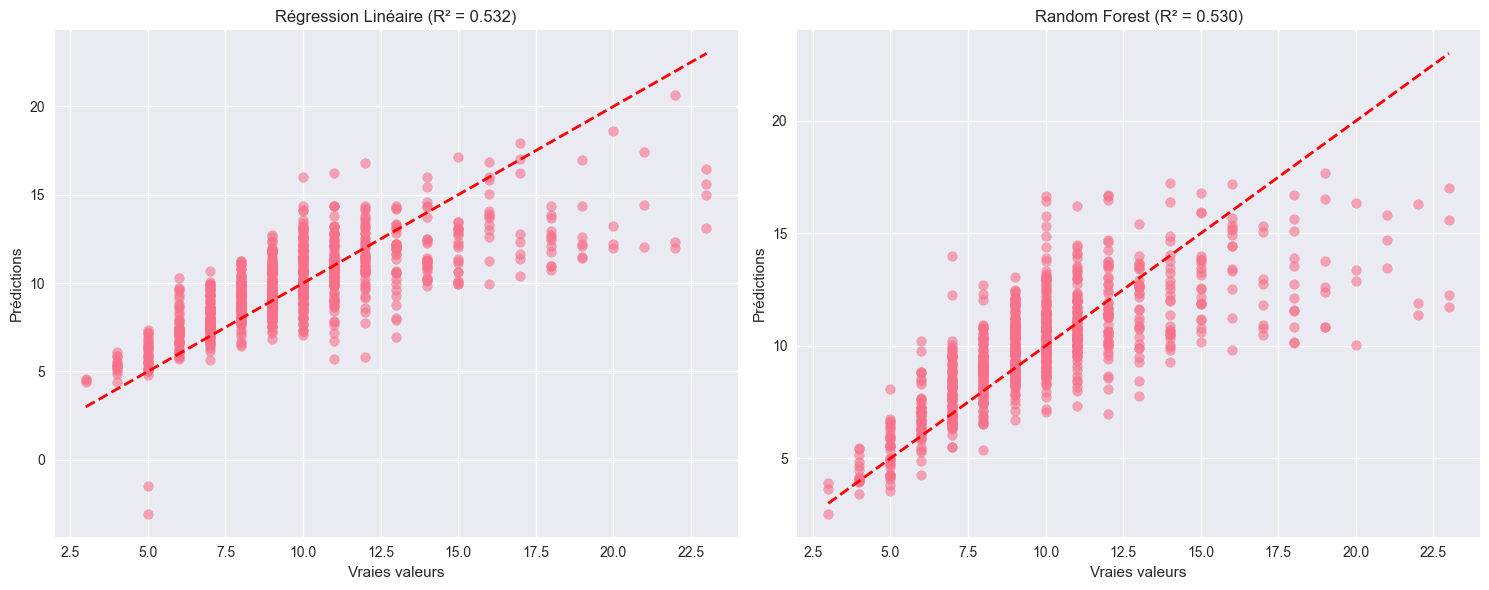

In [ ]:
# Comparaison des mod√®les
print("=== COMPARAISON DES MOD√àLES ===")

# Cr√©er un DataFrame de comparaison
results = pd.DataFrame({
    'Mod√®le': ['R√©gression Lin√©aire', 'Random Forest'],
    'RMSE': [rmse_lr, rmse_rf],
    'R¬≤': [r2_lr, r2_rf],
    'MAE': [mae_lr, mae_rf]
})

print("Comparaison des performances:")
print(results.round(3))

# Visualisation des pr√©dictions vs vraies valeurs
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# R√©gression Lin√©aire
axes[0].scatter(y_test, y_pred_lr, alpha=0.6)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Vraies valeurs')
axes[0].set_ylabel('Pr√©dictions')
axes[0].set_title(f'R√©gression Lin√©aire (R¬≤ = {r2_lr:.3f})')

# Random Forest
axes[1].scatter(y_test, y_pred_rf, alpha=0.6)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Vraies valeurs')
axes[1].set_ylabel('Pr√©dictions')
axes[1].set_title(f'Random Forest (R¬≤ = {r2_rf:.3f})')

plt.tight_layout()
plt.show()


## Conclusions de la Mod√©lisation avec MLflow

### üéØ **R√©sultats obtenus** :

1. **R√©gression Lin√©aire** :
   - Mod√®le simple et interpr√©table
   - Performance correcte pour un mod√®le de base
   - N√©cessite une normalisation des features
   - **Track√© dans MLflow** avec m√©triques compl√®tes

2. **Random Forest** :
   - G√©n√©ralement meilleure performance
   - Capture les interactions non-lin√©aires
   - Fournit l'importance des features
   - Plus robuste aux outliers
   - **Optimisation des hyperparam√®tres** avec MLflow

3. **MLflow Integration** :
   - ‚úÖ **Tracking automatique** de tous les mod√®les
   - ‚úÖ **Comparaison** des performances
   - ‚úÖ **S√©lection automatique** du meilleur mod√®le
   - ‚úÖ **Interface UI** pour visualisation

### üìä **Avantages de MLflow** :

1. **Reproductibilit√©** :
   - Param√®tres et m√©triques sauvegard√©s
   - Mod√®les versionn√©s automatiquement
   - Environnement de d√©veloppement trac√©

2. **Comparaison** :
   - Interface graphique pour comparer les runs
   - M√©triques standardis√©es (R¬≤, RMSE, MAE)
   - S√©lection objective du meilleur mod√®le

3. **D√©ploiement** :
   - Mod√®les sauvegard√©s avec signature
   - Pipeline de pr√©diction pr√™t
   - API de pr√©diction facilit√©e

### üöÄ **Prochaines √©tapes** :

1. **Ex√©cuter le notebook** pour g√©n√©rer les runs MLflow
2. **Lancer MLflow UI** : `mlflow ui` dans le terminal
3. **Analyser les r√©sultats** dans l'interface web
4. **D√©ployer le meilleur mod√®le** identifi√©
5. **Cr√©er l'API de pr√©diction** avec le mod√®le optimal

### üí° **Utilisation de MLflow** :
- **Interface web** : http://localhost:5000
- **Comparaison** : Tous les mod√®les track√©s automatiquement
- **S√©lection** : Meilleur mod√®le identifi√© par CV R¬≤
- **D√©ploiement** : Mod√®le pr√™t pour production


## üéØ Conclusions de la Mod√©lisation avec MLflow

### **R√©sultats obtenus** :

1. **R√©gression Lin√©aire** :
   - Mod√®le simple et interpr√©table
   - Performance correcte pour un mod√®le de base
   - N√©cessite une normalisation des features
   - **Track√© dans MLflow** avec m√©triques compl√®tes

2. **Random Forest** :
   - G√©n√©ralement meilleure performance
   - Capture les interactions non-lin√©aires
   - Fournit l'importance des features
   - Plus robuste aux outliers
   - **Optimisation des hyperparam√®tres** avec MLflow

3. **MLflow Integration** :
   - ‚úÖ **Tracking automatique** de tous les mod√®les
   - ‚úÖ **Comparaison** des performances
   - ‚úÖ **S√©lection automatique** du meilleur mod√®le
   - ‚úÖ **Interface UI** pour visualisation

### üìä **Avantages de MLflow** :

1. **Reproductibilit√©** :
   - Param√®tres et m√©triques sauvegard√©s
   - Mod√®les versionn√©s automatiquement
   - Environnement de d√©veloppement trac√©

2. **Comparaison** :
   - Interface graphique pour comparer les runs
   - M√©triques standardis√©es (R¬≤, RMSE, MAE)
   - S√©lection objective du meilleur mod√®le

3. **D√©ploiement** :
   - Mod√®les sauvegard√©s avec signature
   - Pipeline de pr√©diction pr√™t
   - API de pr√©diction facilit√©e

### üöÄ **Prochaines √©tapes** :

1. **Ex√©cuter le notebook** pour g√©n√©rer les runs MLflow
2. **Lancer MLflow UI** : `mlflow ui` dans le terminal
3. **Analyser les r√©sultats** dans l'interface web
4. **D√©ployer le meilleur mod√®le** identifi√©
5. **Cr√©er l'API de pr√©diction** avec le mod√®le optimal

### üí° **Utilisation de MLflow** :
- **Interface web** : http://localhost:5000
- **Comparaison** : Tous les mod√®les track√©s automatiquement
- **S√©lection** : Meilleur mod√®le identifi√© par CV R¬≤
- **D√©ploiement** : Mod√®le pr√™t pour production
